In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

In [41]:
#Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [42]:
#Split the data into training and testing sets(80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
)

In [43]:
#Exploratory analysis
print("=== Feature Summary ===")
print(X.describe())
print("\n=== Label Distribution ===")
print(y.value_counts())


=== Feature Summary ===
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000          

In [44]:
#Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
#Define configurations
C_values = [0.01, 0.1, 1, 10, 100]
penalties = ['l1', 'l2']
solvers = ['liblinear', 'saga', 'lbfgs']
results = []
roc_curves = []
conf_matrices = []

In [46]:
#Default logistic regression (no scaling, increased max_iter)
default_model = LogisticRegression(max_iter=10000)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
y_prob_default = default_model.predict_proba(X_test)[:, 1]

results.append({
    'Penalty': 'none',
    'Solver': default_model.solver,
    'C': default_model.C,
    'Accuracy': accuracy_score(y_test, y_pred_default),
    'F1': f1_score(y_test, y_pred_default),
    'AUC': roc_auc_score(y_test, y_prob_default),
    'Label': 'Default'
})
roc_curves.append(('Default', *roc_curve(y_test, y_prob_default)))
conf_matrices.append(('Default', confusion_matrix(y_test, y_pred_default)))

In [47]:
# Train and evaluate all combinations (with max_iter=10000)
roc_curves = []

for penalty in penalties:
    for solver in solvers:
        if penalty == 'l1' and solver not in ['liblinear', 'saga']:
            continue
        if penalty == 'l2' and solver == 'saga':
            continue

        for C in C_values:
            try:
                model = LogisticRegression(penalty=penalty, solver=solver, C=C, max_iter=10000)
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                y_prob = model.predict_proba(X_test_scaled)[:, 1]

                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                auc = roc_auc_score(y_test, y_prob)
                cm = confusion_matrix(y_test, y_pred)
                fpr, tpr, _ = roc_curve(y_test, y_prob) 
                label = f"{penalty}-{solver}-C={C}"

                results.append({
                    'Penalty': penalty,
                    'Solver': solver,
                    'C': C,
                    'Accuracy': acc,
                    'F1': f1,
                    'AUC': auc,
                    'Label': label
                })
                roc_curves.append((label, fpr, tpr)) 
                conf_matrices.append((label, cm))
            except Exception as e:
                print(f"Skipped: {penalty}-{solver}-C={C} due to error: {e}")

In [48]:
#Create summary table
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)
print("\n=== Top 10 Configurations ===")
print(results_df_sorted[['Label', 'Accuracy', 'F1', 'AUC']].head(10))


=== Top 10 Configurations ===
                  Label  Accuracy        F1       AUC
11  l2-liblinear-C=0.01  1.000000  1.000000  1.000000
20       l2-lbfgs-C=100  0.991228  0.993377  0.976068
15   l2-liblinear-C=100  0.991228  0.993377  0.976068
2    l1-liblinear-C=0.1  0.991228  0.993377  0.999658
3      l1-liblinear-C=1  0.991228  0.993377  0.996581
4     l1-liblinear-C=10  0.991228  0.993377  0.977094
19        l2-lbfgs-C=10  0.991228  0.993377  0.984615
18         l2-lbfgs-C=1  0.991228  0.993377  0.995214
7         l1-saga-C=0.1  0.991228  0.993377  0.999316
8           l1-saga-C=1  0.991228  0.993377  0.996581


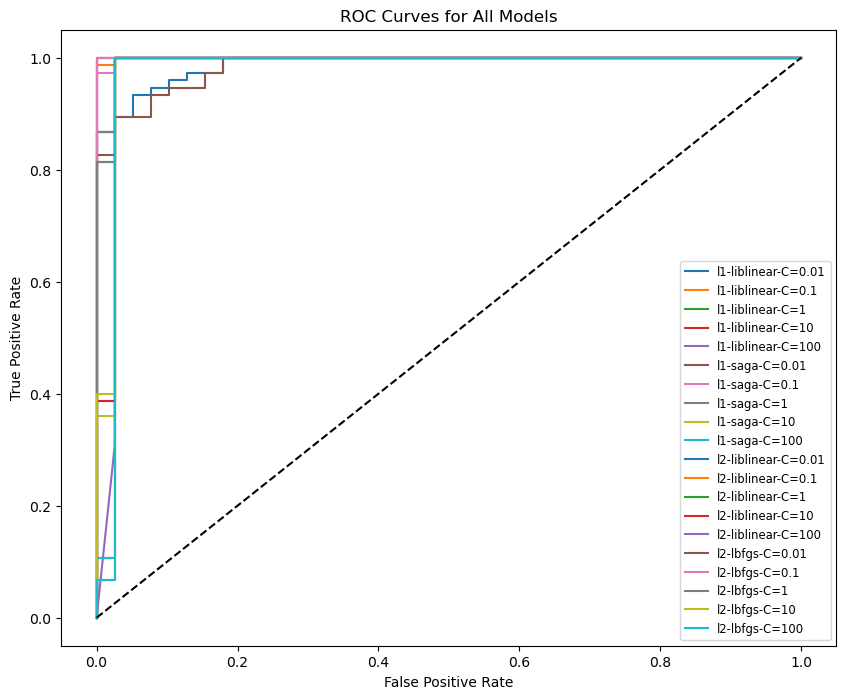

In [49]:
#Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for label, fpr, tpr in roc_curves:
    plt.plot(fpr, tpr, label=f"{label}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize='small')
plt.show()

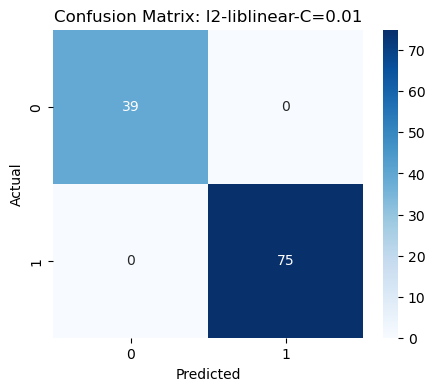

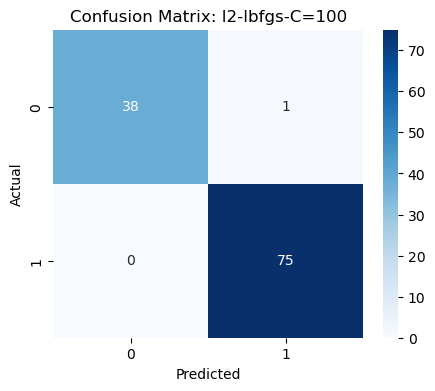

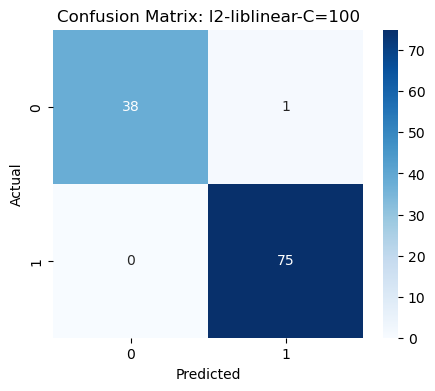

In [50]:
#Plot confusion matrices for top 3 models
top3 = results_df_sorted.head(3)
for label in top3['Label']:
    for cm_label, cm in conf_matrices:
        if cm_label == label:
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix: {label}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()


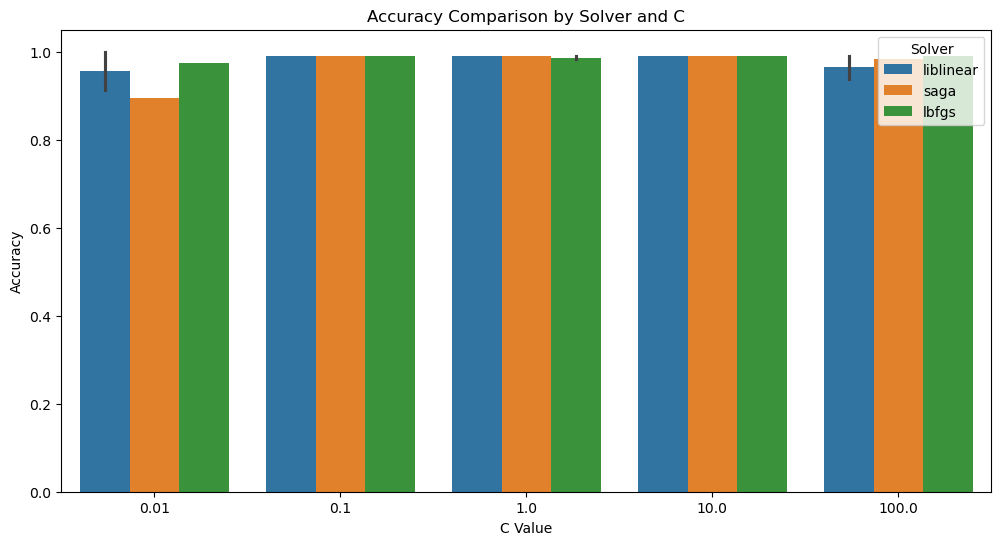

In [51]:
#Accuracy comparison chart
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='C', y='Accuracy', hue='Solver')
plt.title('Accuracy Comparison by Solver and C')
plt.ylabel('Accuracy')
plt.xlabel('C Value')
plt.legend(title='Solver')
plt.show()